
=== Per-file stats ===
[noS  (mRGCresp_chips_10GY_9-4_XYZ_dt10ms_T10.mat)]  N=10371  mean=25.9251  var=273.531  std=16.5388  min/median/max=-17.1827/22.9709/92.6399
          p01=-2.67454  p05=3.60532  p25=13.6611  p75=35.968  p95=57.127  p99=69.7218
[withS(mRGCresp_chips_10GY_9-4_XYZ_dt10ms_T10.mat)]  N=10371  mean=35.0932  var=323.986  std=17.9996  min/median/max=-15.1218/33.1716/99.6741
          p01=2.62532  p05=9.04455  p25=21.197  p75=47.2477  p95=67.5378  p99=79.265
Pearson r = 0.924826

[noS  (mRGCresp_chips_10PB_4-2_XYZ_dt10ms_T10.mat)]  N=10371  mean=4.35023  var=7.76705  std=2.78694  min/median/max=-2.86918/3.85297/15.6119
          p01=-0.440982  p05=0.592973  p25=2.28349  p75=6.03494  p95=9.61875  p99=11.7527
[withS(mRGCresp_chips_10PB_4-2_XYZ_dt10ms_T10.mat)]  N=10371  mean=5.67562  var=8.83093  std=2.97169  min/median/max=-2.57062/5.34732/16.6273
          p01=0.340891  p05=1.41802  p25=3.41252  p75=7.60401  p95=11.1109  p99=13.0857
Pearson r = 0.942889

[noS  (mRGCresp

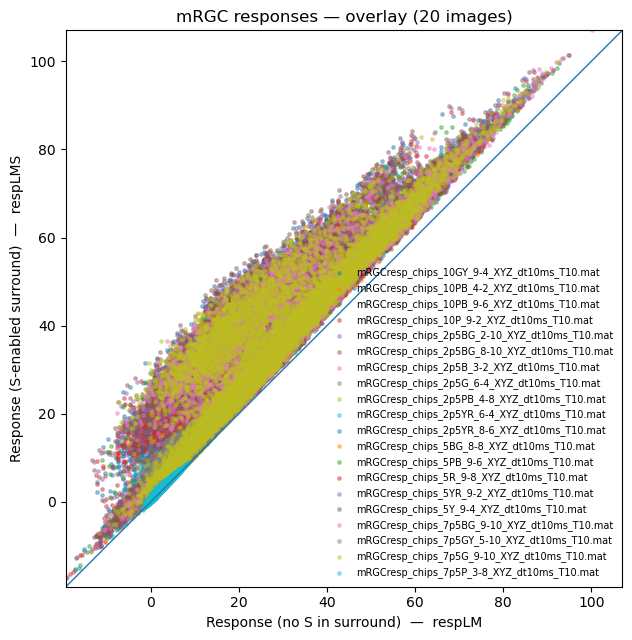

=== Summary ===
Plotted 20 files. Axis limits [-19.2295, 107.029] (shared).


In [3]:
# --- mRGC response quick analysis: single file or many (overlay) ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path
from typing import Sequence, Tuple

def _as_1d(a):
    a = np.asarray(a)
    return np.ravel(a).astype(np.float64)

def _load_vectors(mat_path: str,
                  noS_key: str = "respLM",
                  withS_key: str = "respLMS") -> Tuple[np.ndarray, np.ndarray]:
    """Load (noS, withS) vectors from a saved .mat."""
    D = loadmat(mat_path, squeeze_me=True)
    if noS_key not in D or withS_key not in D:
        raise KeyError(f"Missing keys in {mat_path}: "
                       f"expected '{noS_key}' and '{withS_key}'. "
                       f"Found: {sorted(D.keys())}")
    x = _as_1d(D[noS_key])    # x-axis: no S in surround
    y = _as_1d(D[withS_key])  # y-axis: S-enabled surround
    if x.shape != y.shape:
        raise ValueError(f"Shape mismatch in {mat_path}: {x.shape} vs {y.shape}")
    return x, y

def _print_stats(name: str, v: np.ndarray):
    q = np.percentile(v, [0, 1, 5, 25, 50, 75, 95, 99, 100])
    print(f"[{name}]  N={v.size}  mean={v.mean():.6g}  var={v.var():.6g}  std={v.std():.6g}  "
          f"min/median/max={q[0]:.6g}/{q[4]:.6g}/{q[-1]:.6g}")
    print(f"          p01={q[1]:.6g}  p05={q[2]:.6g}  p25={q[3]:.6g}  p75={q[5]:.6g}  p95={q[6]:.6g}  p99={q[7]:.6g}")

def analyze_mrgc_response_mat(mat_path: str,
                              noS_key: str = "respLM",
                              withS_key: str = "respLMS",
                              marker_size: float = 6.0,
                              alpha: float = 0.5):
    """
    Single-file scatter: x = noS (respLM), y = withS (respLMS).
    Prints stats for both and correlation; draws y=x.
    """
    mat_path = str(mat_path)
    x, y = _load_vectors(mat_path, noS_key, withS_key)

    # Stats
    print(f"\nFile: {mat_path}")
    _print_stats("noS", x)
    _print_stats("withS", y)
    corr = np.corrcoef(x, y)[0, 1] if x.size > 1 else np.nan
    print(f"Pearson r(noS, withS) = {corr:.6g}")

    # Scatter
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x, y, s=marker_size, alpha=alpha)
    lo = min(np.min(x), np.min(y))
    hi = max(np.max(x), np.max(y))
    ax.plot([lo, hi], [lo, hi], linewidth=1)
    ax.set_xlabel("Response (no S in surround)  —  respLM")
    ax.set_ylabel("Response (S-enabled surround)  —  respLMS")
    ax.set_title(Path(mat_path).name)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

def overlay_scatter(mat_paths: Sequence[str],
                    noS_key: str = "respLM",
                    withS_key: str = "respLMS",
                    marker_size: float = 6.0,
                    alpha: float = 0.4):
    """
    Multi-file overlay: each file plotted as its own color on the SAME axes.
    Prints per-file stats and a small summary at the end.
    """
    mat_paths = [str(p) for p in mat_paths]
    if len(mat_paths) == 0:
        raise ValueError("No .mat paths provided.")

    # Preload everything to set common axis limits
    loaded = []
    xmins, xmaxs, ymins, ymaxs = [], [], [], []
    print("\n=== Per-file stats ===")
    for p in mat_paths:
        x, y = _load_vectors(p, noS_key, withS_key)
        loaded.append((p, x, y))
        _print_stats(f"noS  ({Path(p).name})", x)
        _print_stats(f"withS({Path(p).name})", y)
        print(f"Pearson r = {np.corrcoef(x, y)[0,1]:.6g}\n")
        xmins.append(np.min(x)); xmaxs.append(np.max(x))
        ymins.append(np.min(y)); ymaxs.append(np.max(y))

    lo = float(min(min(xmins), min(ymins)))
    hi = float(max(max(xmaxs), max(ymaxs)))

    # Plot
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    for p, x, y in loaded:
        ax.scatter(x, y, s=marker_size, alpha=alpha, label=Path(p).name)
    ax.plot([lo, hi], [lo, hi], linewidth=1)
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("Response (no S in surround)  —  respLM")
    ax.set_ylabel("Response (S-enabled surround)  —  respLMS")
    ax.set_title(f"mRGC responses — overlay ({len(mat_paths)} images)")
    ax.legend(fontsize=7, loc="best", frameon=False)
    plt.tight_layout()
    plt.show()

    # Brief summary
    print("=== Summary ===")
    print(f"Plotted {len(mat_paths)} files. Axis limits [{lo:.6g}, {hi:.6g}] (shared).")

# --- Usage options (pick ONE) ---

# 1) Single file:
# mat_path = "/Users/kate/Documents/retina-model/20251113_runAllImages/train/mRGCresp_trial_000001_initial_XYZ_dt10ms_T10.mat"
# analyze_mrgc_response_mat(mat_path)

# 2) Many files (overlay), e.g., first 3 train files:
from glob import glob
files = sorted(glob("/Users/kate/Documents/retina-model/20251113_runAllImages/chips/*.mat"))[:20]
overlay_scatter(files)
